## Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import warnings

import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

## Set Option

In [4]:
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

## Read Data

In [7]:
df_loan = pd.read_csv("/content/drive/MyDrive/Internship Project Team/Dataset/LoanExport.csv")

## User defined function

In [8]:
# Function for replace the Not Available values to "nan"
def feature_nan(df):
  df.replace('X', np.NaN, inplace = True)
  df['CreditScore'].replace( 0, np.NaN, inplace = True)
  df['LTV'].replace( 0, np.NaN, inplace = True)
  df['Units'].replace( 0, np.NaN, inplace = True)
  return(df)

In [9]:
# Function for converting MSA feature to [1,0]
def feature_msa(df):
  df['MSA'].iloc[df['MSA'].notnull()] = 1
  df['MSA'].fillna(0, inplace = True)
  df['MSA'] = df['MSA'].astype('category')
  return(df)

In [10]:
# Function for correct the data type of features
def feature_dtype(df):
  df['MSA'] = df['MSA'].astype('object')
  df['Units'] = df['Units'].astype('object')
  df['EverDelinquent'] = df['EverDelinquent'].astype('object')
  return(df)

In [11]:
# Function for strip the column values
def feature_strip(df):
  cols = df.select_dtypes(object).columns
  df[cols] = df[cols].apply(lambda x: x.str.strip())
  return(df)

In [12]:
# Function for drop the unwanted columns
def feature_drop(df):
  df.drop(columns = ['OCLTV', 'PropertyState', 'PostalCode', 'LoanSeqNum', 'SellerName', 'ServicerName', 'MonthsDelinquent', 'FirstPaymentDate', 'MaturityDate', 'ProductType'],axis = 1, inplace = True)
  return(df)

## Data Preprocessing

In [13]:
df_process = df_loan.copy() # Create a copy of dataset

Calling function **feature_strip()** for strip the whitespace of feature values. While analysing the date whitespace is found on feature values of **PropertyType and MSA**

In [14]:
df_process= feature_strip(df_process)

While analysing the data we can see that there are lot of Not Applicable values. In the dataset it is mentioned as X or 0. We are replacing these values with NaN by calling function **feature_nan()**

In [15]:
df_process = feature_nan(df_process)

Initially we are having null values only in the feature "SellerName". After this we can see lot of other features which contains null values.

In [16]:
df_process.isnull().sum()

CreditScore            1189
FirstPaymentDate          0
FirstTimeHomebuyer    78015
MaturityDate              0
MSA                   39100
MIP                       0
Units                     2
Occupancy                 0
OCLTV                     0
DTI                       0
OrigUPB                   0
LTV                       5
OrigInterestRate          0
Channel                   0
PPM                    5405
ProductType               0
PropertyState             0
PropertyType             22
PostalCode            98310
LoanSeqNum                0
LoanPurpose               0
OrigLoanTerm              0
NumBorrowers            339
SellerName            24994
ServicerName              0
EverDelinquent            0
MonthsDelinquent          0
MonthsInRepayment         0
dtype: int64

We are going to delete the null values of **PropertyType, Units and LTV**, since the null value rows are very less.

In [17]:
df_process.dropna(subset = ['PropertyType', 'Units', 'LTV'], inplace = True)

Here we are converting feature **MSA** to 1 and 0. Since this feature provide the information of Metropolitan Division code, we convert the feature to 1 if the Metropolitan Division code is availabe and converted to 0 if code is not present. The function **feature_msa()** to convert this.

In [18]:
df_process = feature_msa(df_process)

Here we convert the features to correct datatype by calling function **feature_dtype()**

In [19]:
df_process = feature_dtype(df_process)

Droping of unwanted features by calling function **feature_drop()**

In [20]:
df_process = feature_drop(df_process)

Here we deleted below features ['OCLTV', 'PropertyState', 'PostalCode', 'LoanSeqNum', 'SellerName', 'ServicerName', 'MonthsDelinquent', 'FirstPaymentDate', 'MaturityDate', 'ProductType']
1. OCLTV - "OCLTV" is highly correlated with LTV so we deleted it.
2. PropertyState - Repayment capacity is depends on customer not with the state of the property.
3. PostalCode - Repayment capacity is depends on customer not with the PostalCode.
4. LoanSeqNum - This is a unique value of the disbursed loan.
5. SellerName - Repayment capacity is depends on customer not depends on the seller.
6. ServicerName - Repayment capacity is depends on customer not depends on the servicer.
7. MonthsDelinquent - We observed a relation between the "EverDelinquent" and "MonthsDelinquent". Only if the EverDelinquent is 1, then only values present on MonthsDelinquent. Since EverDelinquent is a categorical varibale we retained that.
8. FirstPaymentDate - Since "OrigLoanTerm" is the difference of "FirstPaymentDate" and "MaturityDate" we deleted.
9. MaturityDate - Since "OrigLoanTerm" is the difference of "FirstPaymentDate" and "MaturityDate" we deleted.
10. ProductType - There is only one feature we are having. So we deleted it.

### Label Encoding & Scalling

Here we are using LabelEncoding for converting the Object datatype to numeric datatype. We mask the **NaN** values, so that it will not get encoded. After this we used standard scalling for scale the data.

In [21]:
label_encoder = LabelEncoder()
original = df_process
mask = df_process.isnull()
df_process = df_process.astype(str).apply(label_encoder.fit_transform).where(~mask, original)

In [22]:
# Standard scalling
scale= StandardScaler()
df_scaled = scale.fit_transform(df_process)

### Split dataset into Null and Non Null datasets

We are spliting the data contains the Null and Non Null dataset to avoid overfitting.

In [23]:
df_notnull = df_process[df_process.isnull().any(axis=1) == False] 
df_null = df_process[df_process.isnull().any(axis=1) == True]

## KNN Imputer 

Here we are using KNN Imputer to impute the missing values.

In [24]:
imputer = KNNImputer()
imputer.fit(df_notnull)

KNNImputer()

In [25]:
df_imputed = imputer.fit_transform(df_null) # Take nearly 10min

In [26]:
df_processed = pd.DataFrame(df_imputed,columns = df_process.columns)

In [27]:
# Combine the NonNull rows and Imputed NUllvalue rows.
df_final = df_notnull.append(df_processed)

# Sort with index
df_final.sort_index(axis = 0, inplace = True)

## Model Building

###1) Classify the dataset using K Mean Clustering (Model 1)

In [28]:
pca = PCA(n_components = 18)
df_pca = pca.fit_transform(df_final)

In [29]:
kmeans = KMeans(n_clusters=2) # Since we have to do binary classification for predicting the customer make the prepayment
X_clustered = kmeans.fit_predict(df_pca)

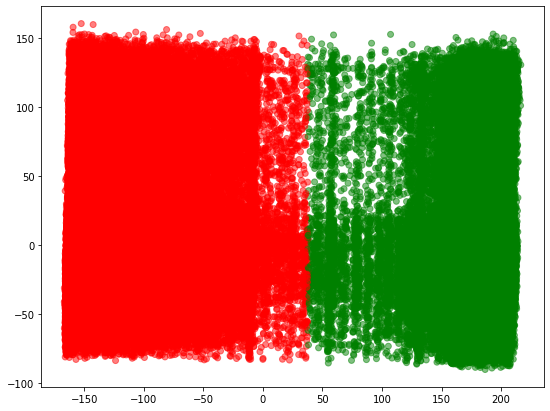

In [30]:
# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (9,7))
plt.scatter(df_pca[:,0],df_pca[:,2], c= label_color, alpha=0.5) 
plt.show()

In [31]:
X_clustered = pd.Series(X_clustered, name="Clustered")
df_final.reset_index(inplace=True, drop=True)
df_data = pd.concat([df_final,X_clustered], axis = 1)

## Train and Test split

In [32]:
X = df_data.iloc[:,0:18]
y = df_data['Clustered']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(203995, 18) (87427, 18) (203995,) (87427,)


## Logistic Regression

In [34]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [35]:
# Prediction

y_pred=logreg.predict(X_test)

**Model Evaluation**

Text(0.5, 257.44, 'Predicted label')

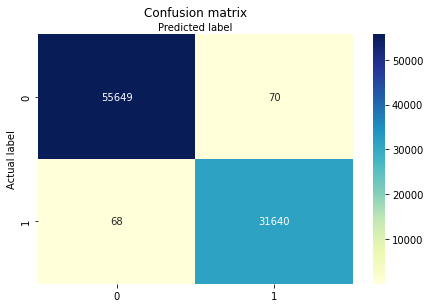

In [36]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [37]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9984215402564425
Precision: 0.9977924944812362
Recall: 0.9978554308061057


## K-Nearest Neighbor(KNN)

In [38]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test) # Will take 7 min

**Model Evaluation**

Text(0.5, 257.44, 'Predicted label')

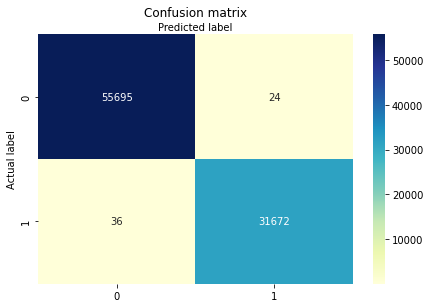

In [39]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.999313713154975
Precision: 0.9992428066633013
Recall: 0.9988646398385266


We will try to find in which Class the customers having the PPM and consider that class of customers might prepay their loans.

###2) Considering "PPM" as target variable (Model 2)

**Spliting data into Features and Target**

In [59]:
X = df_final.drop(columns = ['PPM'], axis = 1)
y = df_final['PPM']
y = y.astype('int')

In [60]:
X_scaled = scale.fit_transform(X)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state = 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(203995, 17) (87427, 17) (203995,) (87427,)


###Logistic Regression

In [62]:
model_lr= LogisticRegression(solver='newton-cg', class_weight='balanced')
model_lr.fit(X_train,y_train)
model_lr.score(X_test, y_test)

0.6546718976975077

In [63]:
y_pred = model_lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.79     86255
           1       0.03      0.72      0.05      1172

    accuracy                           0.65     87427
   macro avg       0.51      0.69      0.42     87427
weighted avg       0.98      0.65      0.78     87427



Text(0.5, 257.44, 'Predicted label')

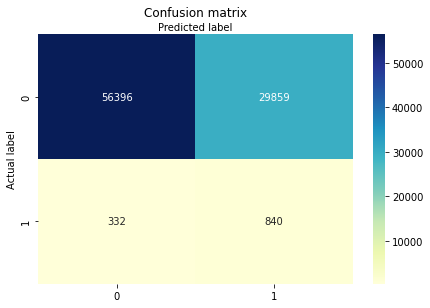

In [68]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

###K-Nearest Neighbors

In [64]:
classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train) 

KNeighborsClassifier()

In [65]:
preds = classifier.predict(X_test)
print(classification_report(y_test, preds))

KeyboardInterrupt: ignored